# 0.0 IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import numpy as np

from sklearn import cluster as c
from matplotlib import pyplot as plt
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Victor\Desktop\repos\pa005_clustering

## 0.1. Auxiliar Functions

## 0.2. Load Data

In [3]:
data_raw = pd.read_csv('datasets/Ecommerce.csv', encoding = 'unicode_escape')

data_raw = data_raw.drop(columns = ['Unnamed: 8'])

# 1.0. Data Description

In [4]:
df1 = data_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## 1.2. Data Dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df1 = df1.dropna(subset=['description', 'customer_id'])

In [10]:
print(f'Total quantity of NA: {df1.isnull().sum().sum()}')

Total quantity of NA: 0


## 1.6. Change Types

In [11]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

## 1.7. Descriptive Statistics

# 2.0. Feature Engineering

In [12]:
df2 = df1.copy()

## 2.1. Feature Creation

In [13]:
# data reference
cols_to_drop = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country']
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [14]:
# Gross Revenue (Faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg Ticket
avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue' : 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')



# 3.0. Data Filtering

In [15]:
df3 = df_ref.copy()

# 4.0. EDA

In [16]:
df4 = df3.copy()

# 5.0. Data Preparation

In [17]:
df5 = df4.copy()

# 6.0. Feature Selection

In [18]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine Tunning

In [19]:
X = df6.drop(columns=['customer_id'])

## 7.1. Within-Cluster Sum of Square (WSS)

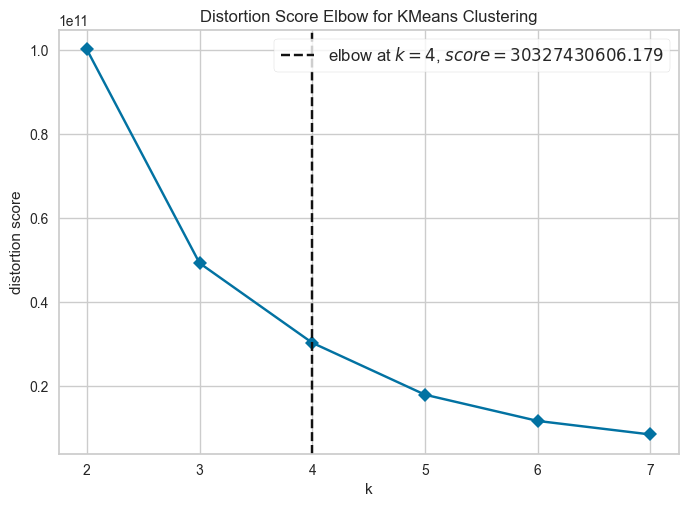

In [20]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

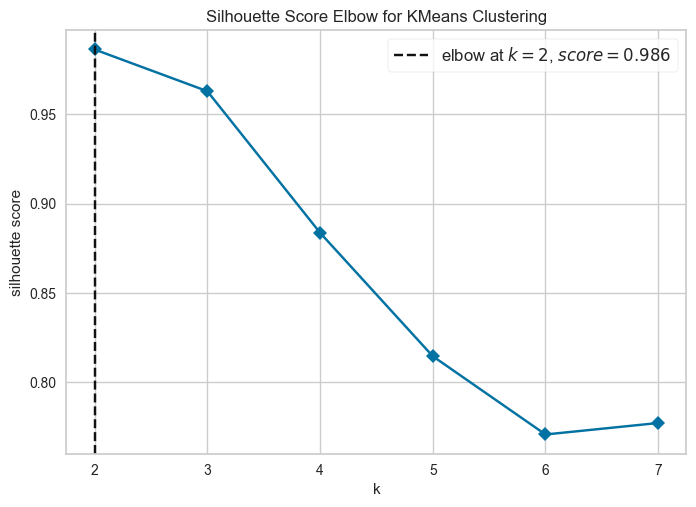

In [21]:
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

### 7.2.1 Silhoette Analysis

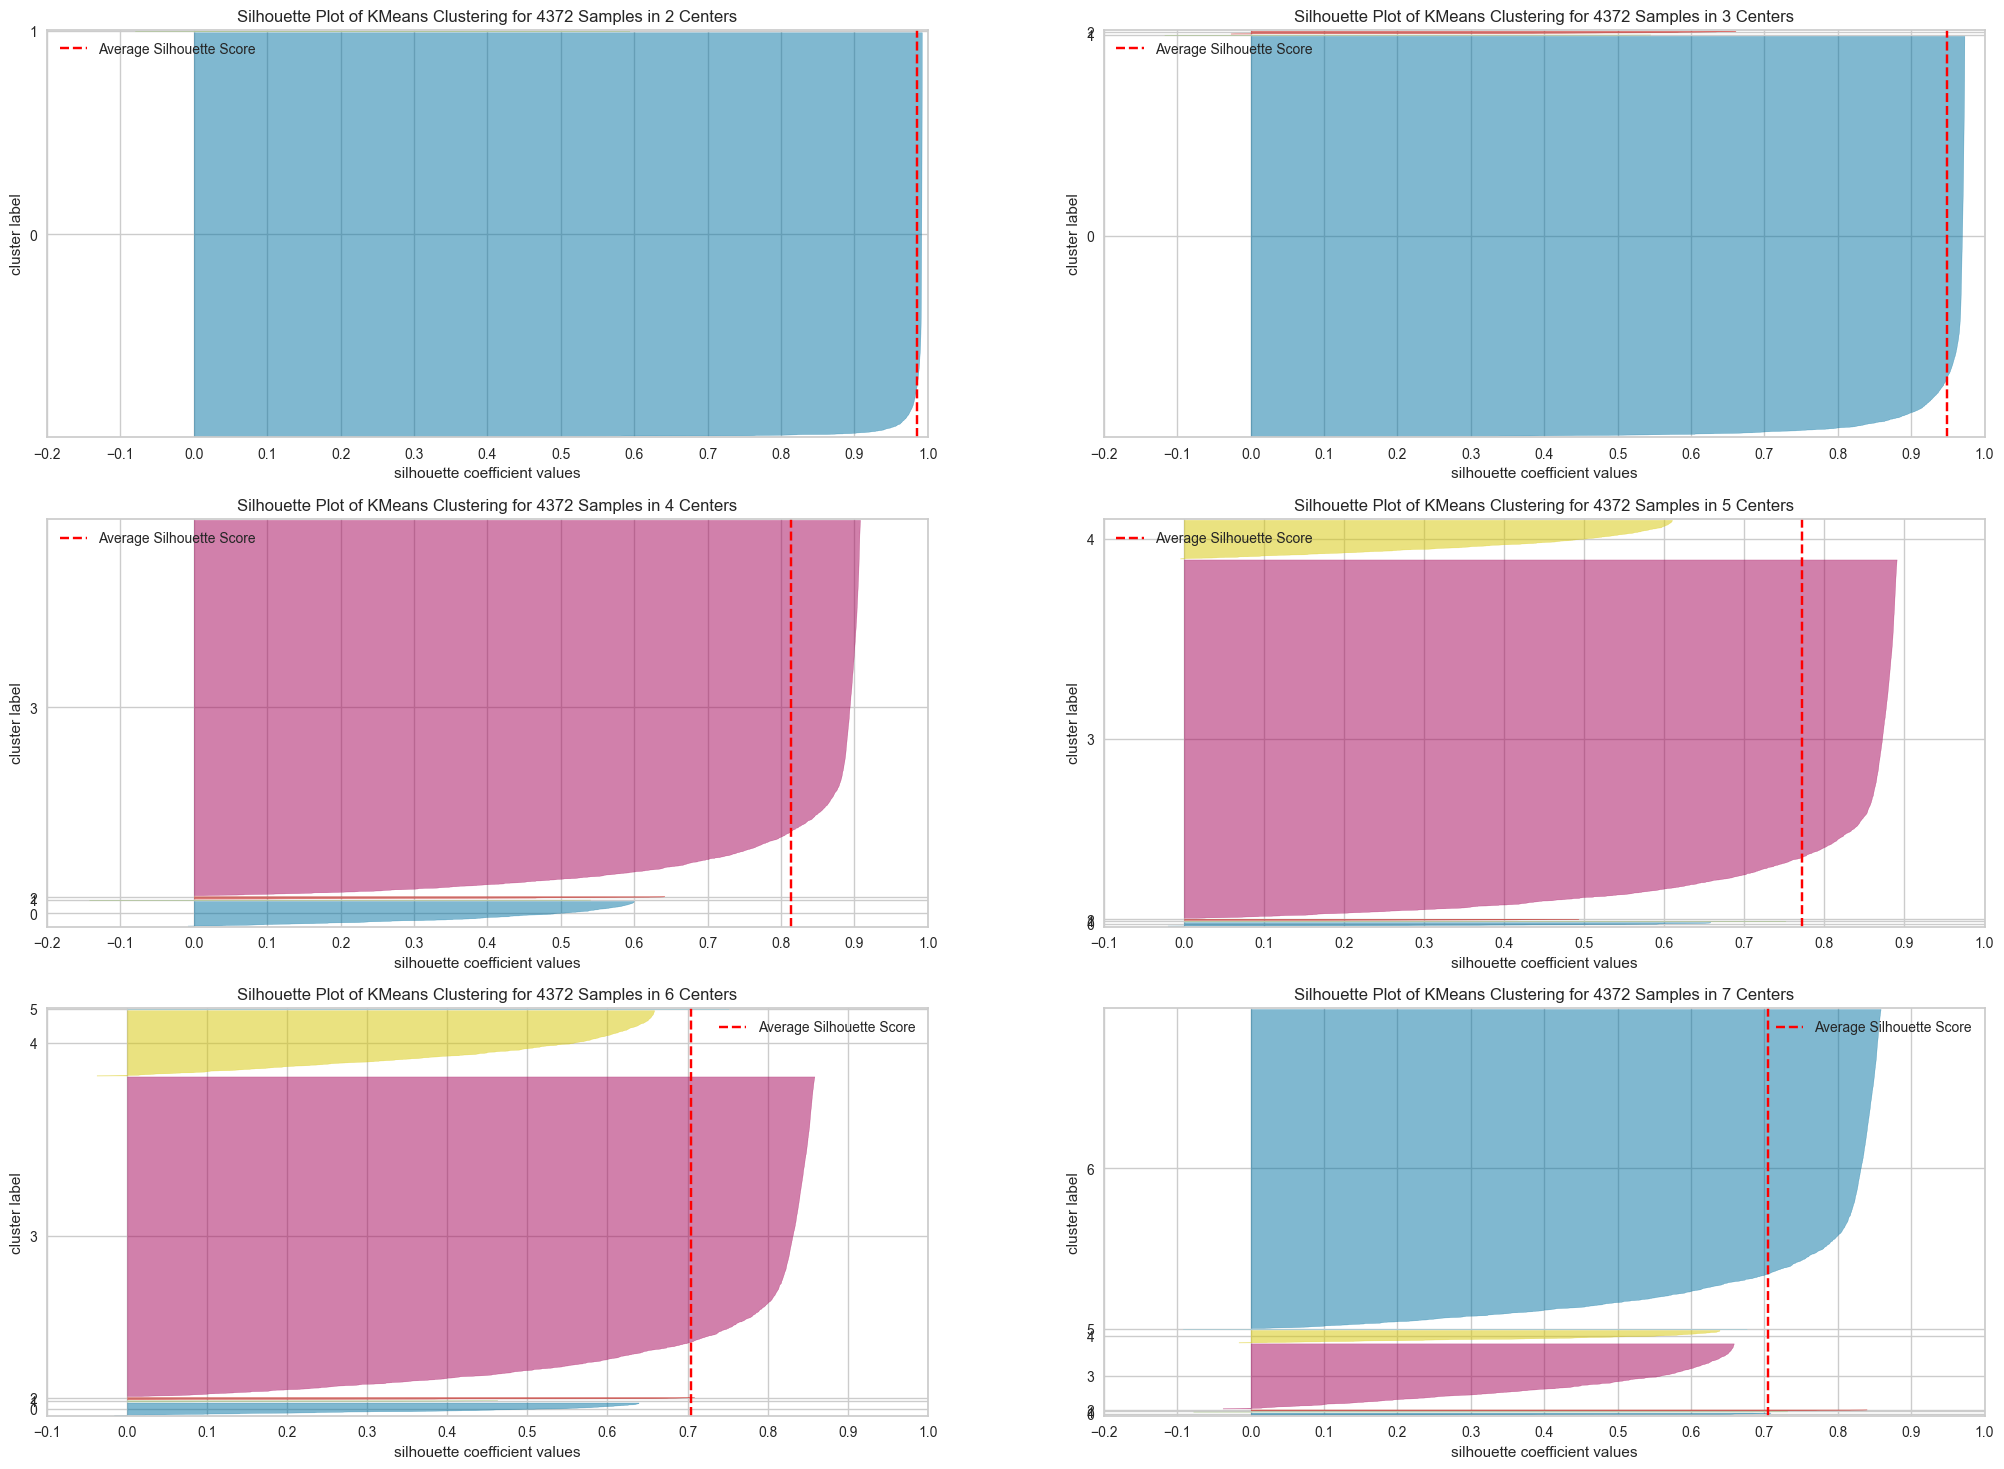

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. Model Training

## 8.1 KMeans

In [28]:
# model difnition
k = 5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [29]:
## WSS
print(f'WSS value: {kmeans.inertia_}')

## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 23025593917.56903
SS value: 0.7723524828605949


# 9.0. Cluster Analysis

## 9.1. Visualization Inspection

### 9.1.1 2d plot

In [30]:
df9 = df6.copy()
df9['cluster'] = labels
df9['cluster'] = df9['cluster'].astype('int64')
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850.0,5288.63,302,35,16.950737,4
1,13047.0,3079.10,31,18,15.709694,3
2,12583.0,7187.34,2,18,28.634821,4
3,13748.0,948.25,95,5,33.866071,3
4,15100.0,635.10,330,6,105.850000,3


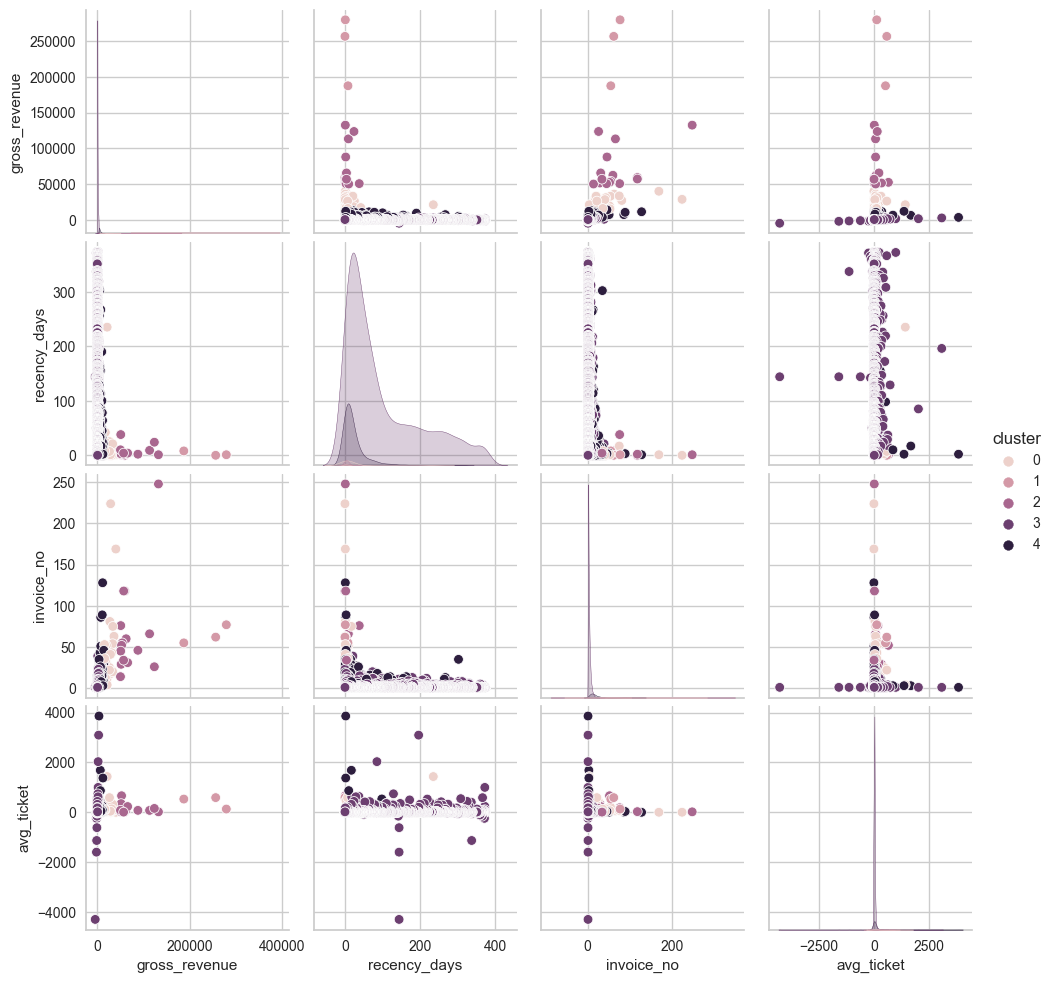

In [31]:
df_viz = df9.drop(columns='customer_id', axis=1)

sns.pairplot(df_viz, hue='cluster')

### 9.1.2 UMAP

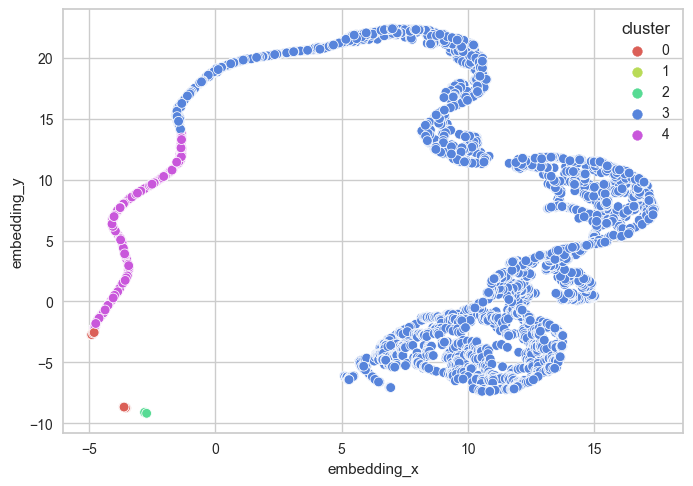

In [42]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())));

## 9.2. Cluster Profile

In [43]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='left', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,38,0.869167,23181.925000,12.868421,43.078947,144.283757
1,1,3,0.068618,241136.560000,3.000000,64.666667,420.140475
2,2,15,0.343092,71423.516000,7.400000,67.866667,147.055408
3,3,3896,89.112534,817.913748,99.906057,3.322382,24.120000
4,4,420,9.606587,5804.281619,25.119048,15.230952,55.151451
